In [9]:
%cd /data/codes/prep_gopt/egs/librispeech/s5/

from pandarallel import pandarallel
from asr import Whisper_STT
from glob import glob
import soundfile as sf
import pandas as pd
import librosa
import random
import json
import re
import os

pandarallel.initialize(nb_workers=5, progress_bar=True)

/data/codes/prep_gopt/egs/librispeech/s5
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [10]:
audio_dir = "/data/audio_data/prep_submission_audio/10"
path = "/data/codes/prep_gopt/egs/librispeech/s5/data/stt/processed/filtered_sents_type_10.csv"
metadata = pd.read_csv(path, index_col=0)
metadata.head()

,sent
0,"{""start_time"": 0.37, ""end_time"": 1.32, ""text"":..."
1,"{""start_time"": 0.23, ""end_time"": 0.66, ""text"":..."
2,"{""start_time"": 0.53, ""end_time"": 1.67, ""text"":..."
3,"{""start_time"": 0.51, ""end_time"": 1.63, ""text"":..."
4,"{""start_time"": 0.48, ""end_time"": 1.31, ""text"":..."


21.70541944444444


<Axes: >

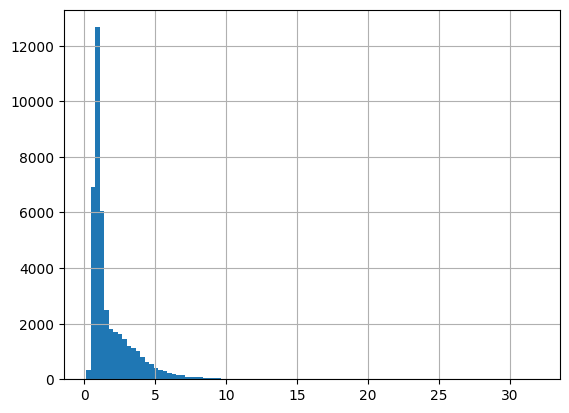

In [11]:
duration = metadata.sent.apply(lambda x: json.loads(x)["end_time"] - json.loads(x)["start_time"])
print(duration.sum()/3600)
duration.hist(bins=100)

In [12]:
seleted_data = metadata[(duration > 0.5) & (duration < 20)].reset_index()
seleted_data["sent"] = seleted_data.sent.apply(lambda x: json.loads(x))

In [13]:
def normalize(text):
    text = re.sub('[\!@#$%^&*\(\)\\\.\'\"\,\?\;\:\+\-\_\/\|~`]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.upper().strip()
    return text

In [14]:
wav_dir = "/data/audio_data/prep_submission_audio/10"

seleted_data["text"] = seleted_data.sent.parallel_apply(lambda x: normalize(x["text"]))
seleted_data["wav_path"] = seleted_data.sent.parallel_apply(lambda x: os.path.join(wav_dir, f'{x["utt_id"]}.wav'))
seleted_data["utt_id"] = seleted_data.sent.parallel_apply(lambda x: x["utt_id"])
seleted_data["spk_id"] = ['0'*(8-len(str(spk_id))) + f'{spk_id}' for spk_id in range(seleted_data.shape[0])]

seleted_data.sort_values("utt_id", inplace=True)

In [15]:
def create_text_file(f, first_column, second_column):
    line = f'{first_column}\t{second_column}'
    f.write(line + "\n")

data_dir = "/data/codes/prep_gopt/egs/librispeech/s5/data/prep/train_processed_type_9"
os.mkdir(data_dir)
wavscp_path = f'{data_dir}/wav.scp'
text_path = f'{data_dir}/text'
spk2utt_path = f'{data_dir}/spk2utt'
utt2spk_path = f'{data_dir}/utt2spk'

with open(wavscp_path, "w", encoding="utf-8") as f:
    seleted_data[0:35000].apply(lambda x: create_text_file(f, x["utt_id"], x["wav_path"]), axis=1)
    
with open(text_path, "w", encoding="utf-8") as f:
    seleted_data[0:35000].apply(lambda x: create_text_file(f, x["utt_id"], x["text"]), axis=1)
    
with open(spk2utt_path, "w", encoding="utf-8") as f:
    seleted_data[0:35000].apply(lambda x: create_text_file(f, x["utt_id"], x["utt_id"]), axis=1)
    
with open(utt2spk_path, "w", encoding="utf-8") as f:
    seleted_data[0:35000].apply(lambda x: create_text_file(f, x["utt_id"], x["utt_id"]), axis=1)

In [16]:
def create_text_file(f, first_column, second_column):
    line = f'{first_column}\t{second_column}'
    f.write(line + "\n")


data_dir = "/data/codes/prep_gopt/egs/librispeech/s5/data/prep/test_processed_type_9"
os.mkdir(data_dir)
wavscp_path = f'{data_dir}/wav.scp'
text_path = f'{data_dir}/text'
spk2utt_path = f'{data_dir}/spk2utt'
utt2spk_path = f'{data_dir}/utt2spk'

with open(wavscp_path, "w", encoding="utf-8") as f:
    seleted_data[35000:].apply(lambda x: create_text_file(f, x["utt_id"], x["wav_path"]), axis=1)
    
with open(text_path, "w", encoding="utf-8") as f:
    seleted_data[35000:].apply(lambda x: create_text_file(f, x["utt_id"], x["text"]), axis=1)
    
with open(spk2utt_path, "w", encoding="utf-8") as f:
    seleted_data[35000:].apply(lambda x: create_text_file(f, x["utt_id"], x["utt_id"]), axis=1)
    
with open(utt2spk_path, "w", encoding="utf-8") as f:
    seleted_data[35000:].apply(lambda x: create_text_file(f, x["utt_id"], x["utt_id"]), axis=1)